# Networks Using Blocks (VGG)


While AlexNet offered empirical evidence that deep CNNs
can achieve good results, it did not provide a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that in chip design
where engineers went from placing transistors
to logical elements to logic blocks.
Similarly, the design of neural network architectures
had grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers.

The idea of using blocks first emerged from the
[Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG)
at Oxford University,
in their eponymously-named *VGG* network.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.

</br>



In [ ]:
#GPU
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)


Tesla T4, 15360 MiB, 15101 MiB



In [ ]:
# import the needed modules

import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



## (**VGG Blocks**)


The basic building block of classic CNNs
is a sequence of the following:

* (i) a convolutional layer
with padding to maintain the resolution,
* (ii) a nonlinearity such as a ReLU,
* (iii) a pooling layer such
as a maximum pooling layer.

</br>
One VGG block consists of a sequence of convolutional layers,
followed by a maximum pooling layer for spatial downsampling.
In the original VGG paper,
the authors
employed convolutions with $3\times3$ kernels with padding of 1 (keeping height and width)
and $2 \times 2$ maximum pooling with stride of 2
(halving the resolution after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.



</br>
The function takes two arguments
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


In [ ]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

## [**VGG Network**]

Like AlexNet and LeNet,
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully-connected layers.

</br>

![vgg](https://github.com/d2l-ai/d2l-en/raw/master/img/vgg.svg)
</br>


The convolutional part of the network connects several VGG blocks (also defined in the `vgg_block` function)
in succession.
The following variable `conv_arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function.
The fully-connected part of the VGG network is identical to that covered in AlexNet.

The original VGG network had 5 convolutional blocks,
among which the first two have one convolutional layer each
and the latter three contain two convolutional layers each.
The first block has 64 output channels
and each subsequent block doubles the number of output channels,
until that number reaches 512.
Since this network uses 8 convolutional layers
and 3 fully-connected layers, it is often called VGG-11.


In [ ]:
batch_size= 64

conv_arch = ((1, 128), (1, 256), (1, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for-loop over `conv_arch`.


In [ ]:

def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    #The first conv and pool layer
    net.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, 
                                   padding='same',
                                   activation='relu', 
                                   input_shape=(32,32, 3)))
    
    #Don't pool to keep the resolution as you stack layers
    #net.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    
    # The fully-connected part
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')]))
    
    net.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
    return net



## Reading the Dataset

Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here
since training an ImageNet model to convergence could take hours or days
even on a modern GPU.
One of the problems with applying AlexNet directly on **CIFAR-10**
is that its (**images have lower resolution**) 
(**than ImageNet images.**)
To make things work, (**we upsample them to $224 \times 224$**)
(generally not a smart practice,
but we do it here to be faithful to the AlexNet architecture).


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()


**Have a look at the data!**


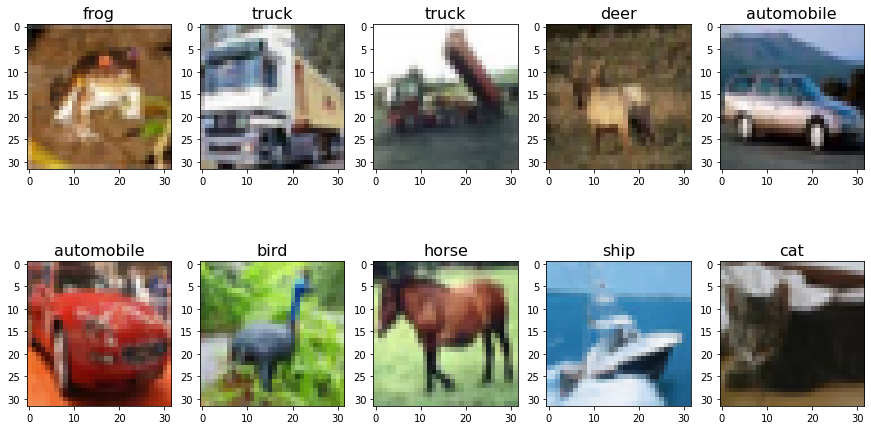

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


fig, ax = plt.subplots(2,5, figsize=(15, 8))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(CLASS_NAMES[label],  fontsize=16)





## Training

### **Building the model**


Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* Loss function - measures how accurate the model is during training, we want to minimize this with the optimizer.
* Optimizer - how the model is updated based on the data it sees and its loss function.
* Metrics - used to monitor the training and testing steps.


In [ ]:
vgg_model = vgg(conv_arch)

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        9472      
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 128)       73856     
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 256)         295168    
                                                                 
 sequential_3 (Sequential)   (None, 4, 4, 512)         1180160   
                                                                 
 sequential_4 (Sequential)   (None, 2, 2, 512)         4719616   
                                                                 
 sequential_5 (Sequential)   (None, 10)                25214986  
                                                                 
Total params: 31,493,258
Trainable params: 31,493,258
No

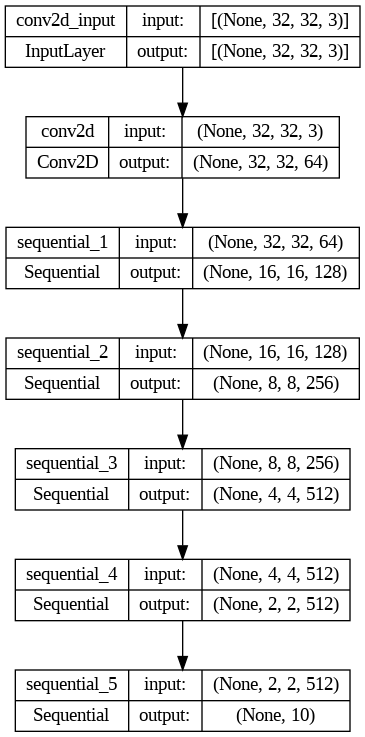

In [ ]:
tf.keras.utils.plot_model(vgg_model, show_shapes=True)

Apart from using a slightly larger learning rate,
the [**model training**] process is similar to that of AlexNet in :numref:`sec_alexnet`.


In [ ]:
history = vgg_model.fit(x_train, y_train,
            epochs=10,
            batch_size=batch_size,
            validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 34s 35ms/step - loss: 2.0788 - accuracy: 0.1939 - val_loss: 1.6555 - val_accuracy: 0.3682
Epoch 2/10
782/782 [==============================] - 27s 35ms/step - loss: 1.5276 - accuracy: 0.4283 - val_loss: 1.3911 - val_accuracy: 0.4955
Epoch 3/10
782/782 [==============================] - 25s 33ms/step - loss: 1.3010 - accuracy: 0.5289 - val_loss: 1.2209 - val_accuracy: 0.5532
Epoch 4/10
782/782 [==============================] - 26s 33ms/step - loss: 1.1505 - accuracy: 0.5902 - val_loss: 1.1553 - val_accuracy: 0.5879
Epoch 5/10
782/782 [==============================] - 26s 33ms/step - loss: 1.0427 - accuracy: 0.6339 - val_loss: 1.0517 - val_accuracy: 0.6329
Epoch 6/10
782/782 [==============================] - 26s 33ms/step - loss: 0.9486 - accuracy: 0.6682 - val_loss: 0.9933 - val_accuracy: 0.6533
Epoch 7/10
782/782 [==============================] - 27s 35ms/step - loss: 0.8756 - accuracy: 0.6951 - val_loss: 0.9477 - val_accuracy:

### Visualize the training and validation accuracy

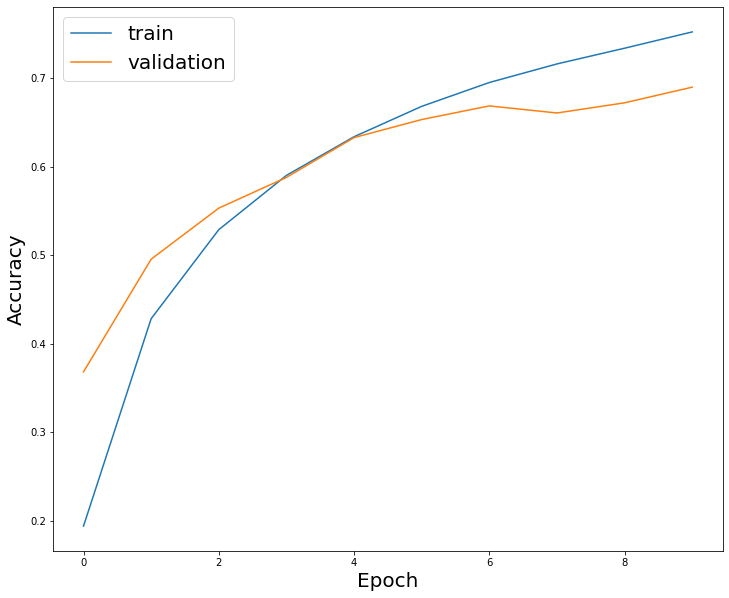

In [ ]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

### Evaluate the trained model


In [ ]:
score = vgg_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9129332304000854
Test accuracy: 0.6898999810218811


### Predict using the trained model


1/1 [==============================] - 0s 20ms/step


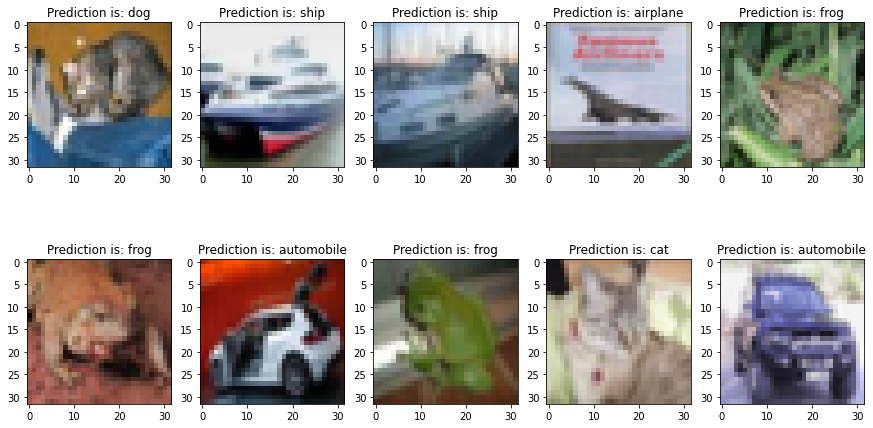

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()
for i in range(10):
    plottable_image = np.reshape(x_test[i], (32, 32, 3))
    ax[i].imshow(plottable_image, cmap='gray_r')
    ax[i].set_title("Prediction is: {}".format(CLASS_NAMES[vgg_model.predict(np.reshape(x_test[i], (1,32,32,3))).argmax()]), fontsize=12)

## Summary

* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.
* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.
* In their VGG paper, Simonyan and Ziserman experimented with various architectures. In particular, they found that several layers of deep and narrow convolutions (i.e., $3 \times 3$) were more effective than fewer layers of wider convolutions.

## Exercises

1. When printing out the dimensions of the layers we only saw 8 results rather than 11. Where did the remaining 3 layer information go?
1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory. Analyze the reasons for this.
1. Try changing the height and width of the images in Fashion-MNIST from 224 to 96. What influence does this have on the experiments?
1. Refer to Table 1 in the VGG paper to construct other common models, such as VGG-16 or VGG-19.
